Notebook demonstrating the recovery of the velcoity shift values from SM-Emp using cross-correlation between the shifted and unshfited target spectrum.

In [1]:
# imports
import astropy.io.fits 
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from astropy.utils.data import get_pkg_data_filename

In [2]:
# read in data
hdul_U_GJ144 = astropy.io.fits.open('/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRU_testing/GJ144_NDRU.fits'); filename = 'GJ144'
hdul_S_GJ144 = astropy.io.fits.open('/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRS_testing/GJ144_NDRS.fits'); filename = 'GJ144'
hdul_R_GJ144 = astropy.io.fits.open('/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRR_testing/GJ144_NDRR.fits'); filename = 'GJ144'

Order 32
    Shift in pixels: 96
    Shift in wl: 1.651030994086455
    Shift in v: 97.41727602589864
Order 33
    Shift in pixels: 96
    Shift in wl: 1.6691586025801675
    Shift in v: 97.41727602599397
Order 34
    Shift in pixels: 96
    Shift in wl: 1.6876828479217627
    Shift in v: 97.41727602599386
Order 35
    Shift in pixels: 96
    Shift in wl: 1.7066240631491605
    Shift in v: 97.41727602608833
Order 36
    Shift in pixels: 96
    Shift in wl: 1.72599458379127
    Shift in v: 97.41727602618273
Order 37
    Shift in pixels: 96
    Shift in wl: 1.7458160253429624
    Shift in v: 97.41727602627238
Order 38
    Shift in pixels: 96
    Shift in wl: 1.7660928499620123
    Shift in v: 97.41727602636632
Order 39
    Shift in pixels: 96
    Shift in wl: 1.7868477360542139
    Shift in v: 97.4172760264604
Order 40
    Shift in pixels: 96
    Shift in wl: 1.8080981067761397
    Shift in v: 97.41727602655517
Order 41
    Shift in pixels: 96
    Shift in wl: 1.8298620145165572
    Shif

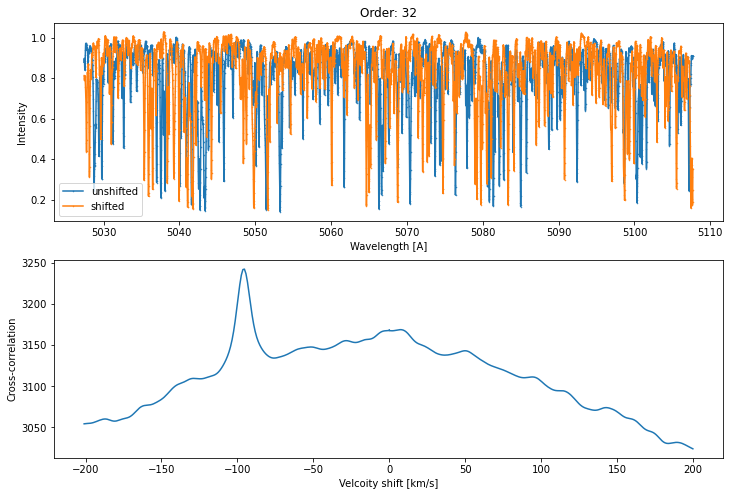

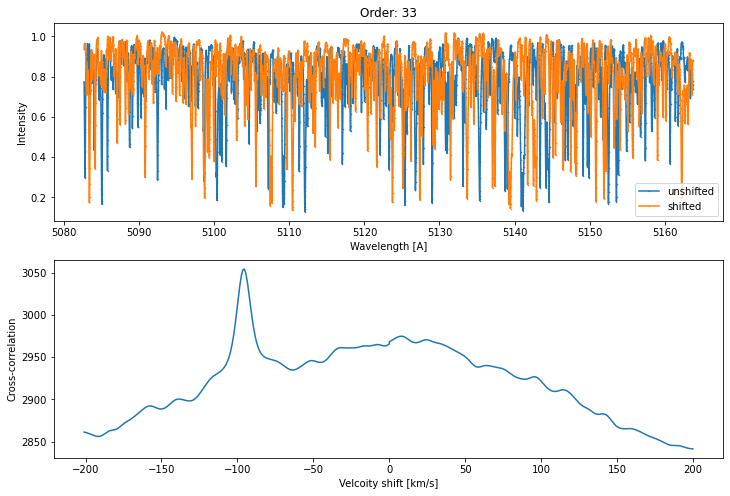

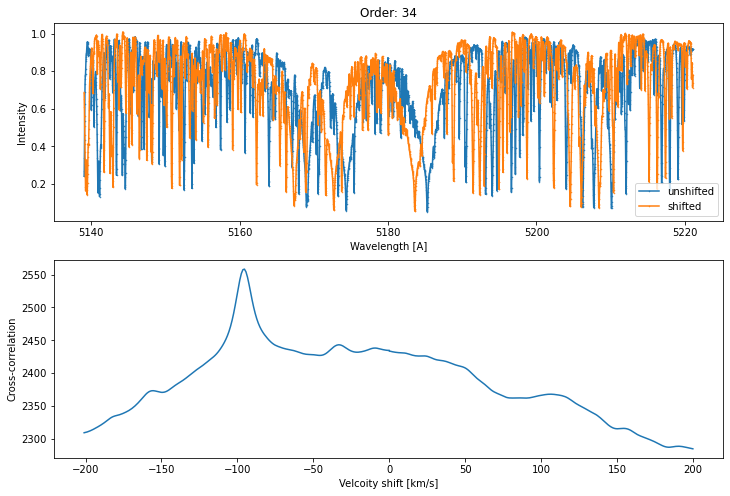

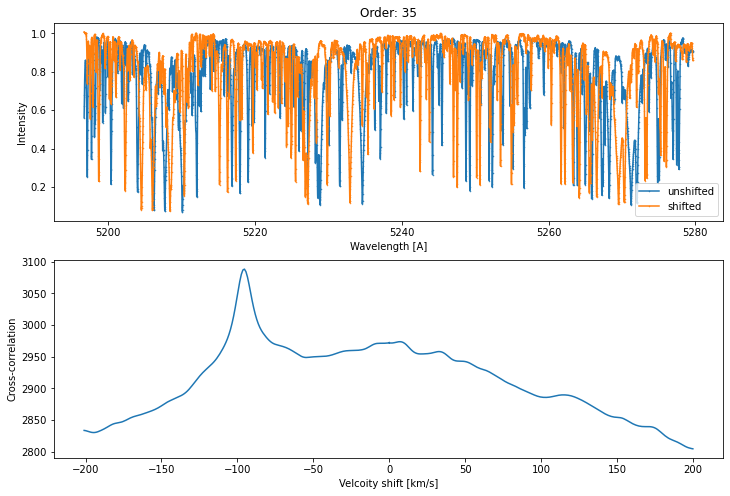

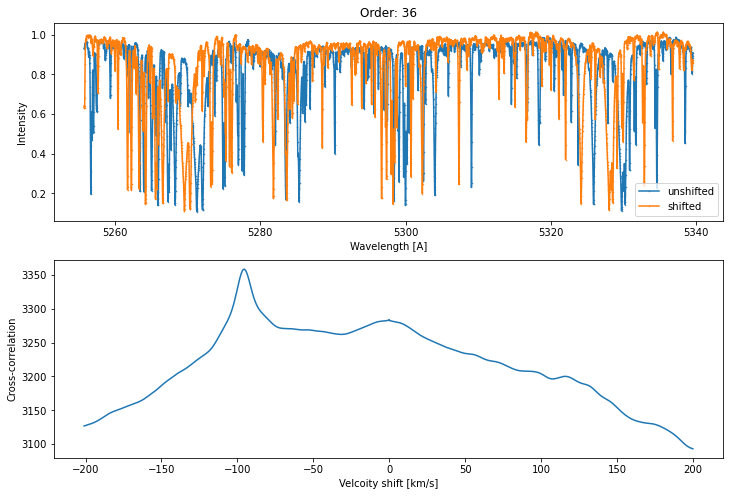

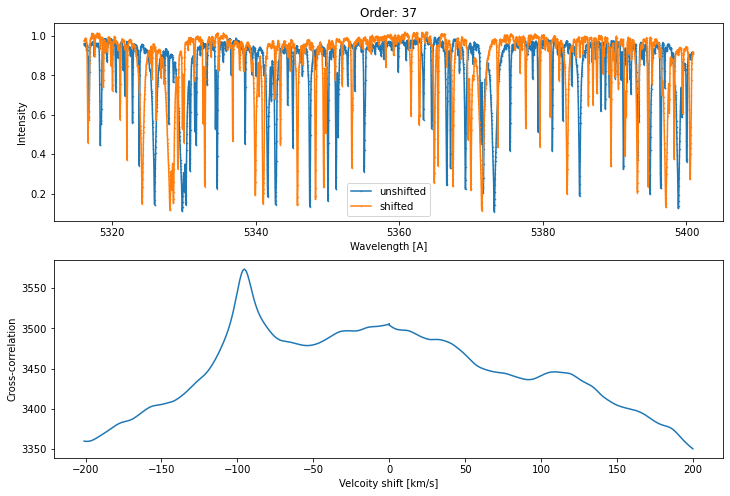

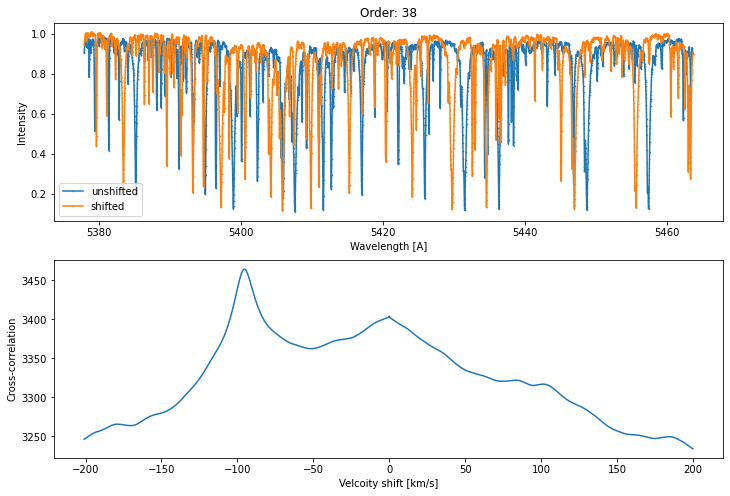

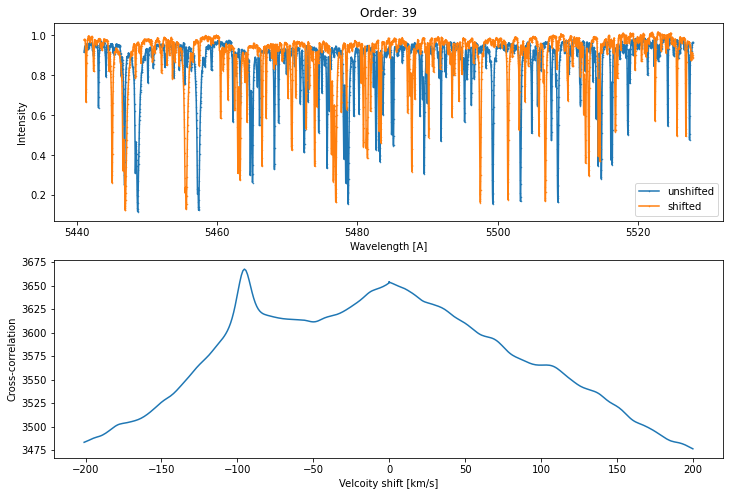

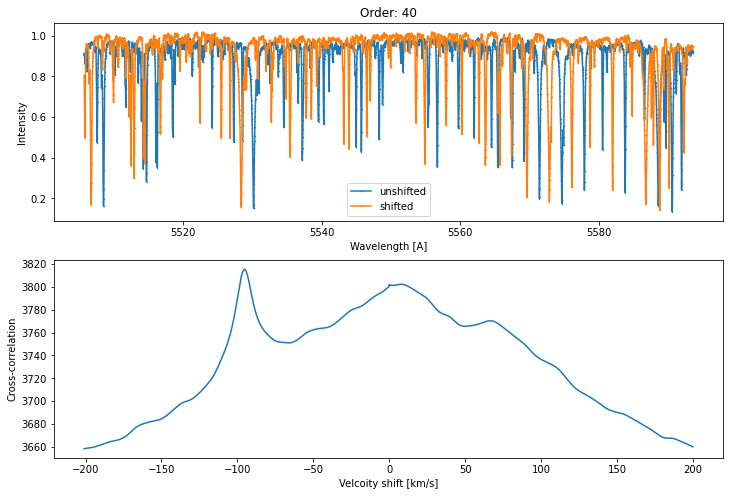

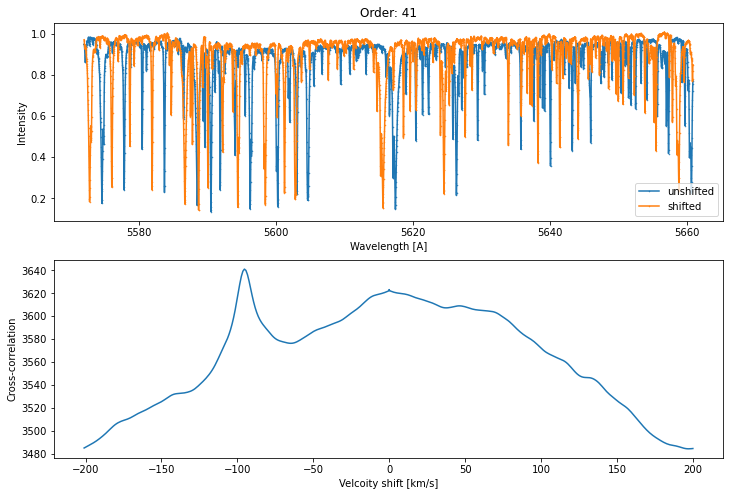

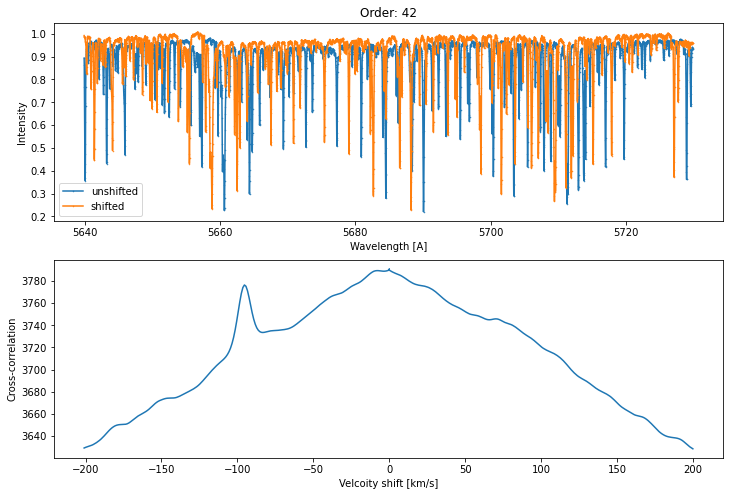

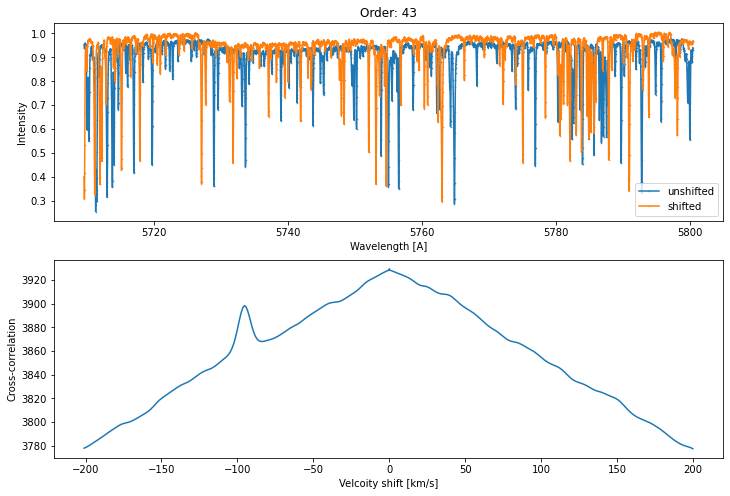

In [33]:
# cross correlate shifted and unshifted spectra to calculate the shift values 

# define the flux an wavelenght values
wl_unshifted = hdul_U_GJ144[1].data
wl_shifted = hdul_S_GJ144[1].data
unshifted = hdul_U_GJ144[0].data
shifted = hdul_S_GJ144[0].data

# define constants and APF wavelenght scale (only used to determine order boundaries)
apf_wave = astropy.io.fits.open('apf_wav.fits')
c = 2.99 * 10**8 #m/s

# create lists to hold shift values
pix_shift_arr = []
wl_shift_arr = []
v_shift_arr = []

for order in np.arange(32,44):
    
    # find order boundaries
    apf_order = apf_wave[0].data[order]
    low_bound = apf_order[0]
    up_bound = apf_order[-1]

    # define data for this order
    idxs_order_shifted = (wl_shifted > low_bound) * (wl_shifted < up_bound) # order 40 for example
    idxs_order_unshifted = (wl_unshifted > low_bound) * (wl_unshifted < up_bound)
    flux_U = unshifted[idxs_order_unshifted]
    flux_S = shifted[idxs_order_shifted]
    wl_U = wl_unshifted[idxs_order_unshifted]
    wl_S = wl_shifted[idxs_order_shifted]
    
    # calculate cross-correlation and calculate shifts i
    xcorr = np.correlate(flux_S, flux_U, mode='full')
    max_xcorr = np.where(xcorr == np.max(xcorr))[0]
    pixel_shift = len(wl_S) - max_xcorr 
    approx_delta_wl = np.mean(wl_U[1:] - wl_U[:-1]) # approximate becuase varies across spectrum
    wl_shift = pixel_shift*approx_delta_wl # approximate becuase uses assumption of constant wl per pixel
    delta_v = c * wl_shift / np.mean(wl_U) / 1000 # km/s
    
    # plot shifted and unshifted spectra for reference
    plt.figure(figsize = [12,8])
    plt.subplot(211)
    plt.plot(wl_U, flux_U, '.-', label = 'unshifted', ms = 1)
    plt.plot(wl_S, flux_S, '.-', label = 'shifted', ms = 1)
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Intensity')
    plt.title('Order: ' + str(order))
    plt.legend()

    # plot cross-correlation results
    plt.subplot(212)
    pix_lags = np.hstack([np.flip(np.arange(0,len(wl_U),1)*(-1))[1:], np.array([0]), np.arange(0,len(wl_U),1)[:-1]])   
    v_lags = pix_lags * approx_delta_wl * c / np.mean(wl_U) / 1000 # approximation becuase assumes constant wl per pixel and uses avg wl value
    xlim_l = np.where(v_lags < -200)[0][-1]
    xlim_u = np.where(v_lags > 200)[0][0]
    plt.plot(v_lags[xlim_l:xlim_u], xcorr[xlim_l:xlim_u])
    plt.xlabel('Velcoity shift [km/s]')
    plt.ylabel('Cross-correlation')

    
    print('Order ' + str(order))
    print('    Shift in pixels: ' + str(pixel_shift[0]))
    print('    Shift in wl: ' + str(wl_shift[0]))
    print('    Shift in v: ' + str(delta_v[0]))
    
    pix_shift_arr += [pixel_shift]
    wl_shift_arr += [wl_shift]
    v_shift_arr += [delta_v]
    
pix_shift_arr = np.array(pix_shift_arr)
wl_shift_arr = np.array(wl_shift_arr)
v_shift_arr = np.array(v_shift_arr)[:,0]

Text(2, 4, 'Median velocity shift value: 97.417')

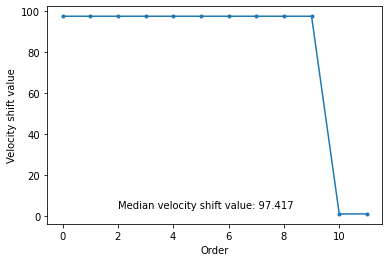

In [32]:
# Find the median shift value

plt.figure()
plt.plot(np.linspace(0,len(v_shift_arr)-1, len(v_shift_arr)), v_shift_arr, '.-')
plt.xlabel('Order')
plt.ylabel('Velocity shift value')
plt.text(2,4,'Median velocity shift value: ' + str(np.round(np.median(v_shift_arr),3)))

Thus, except for the last two orders which are clearly unreliable, the velcoity shift is constant across the spectrum and is in this case (GJ144) approximatley 97.417 km/s. The shift is to the left (ie. to smaller wavelenght values), indicating that the star is moving towards the Earth. 

We want to reverse the shift for any given pixel in the shifted spectrum or residual spectrum. We have shown above that the shift is constant in pixel-space (which is expected becuase the scale is constant in delta log wavelength), so we only need the single pixel shift value for each target. 

In this case, we can simply add the pixel shift value (96) to the pixel value at which a candidate feature occurs in the shifted or residual spectrum in order to determine the pixel at which it would have occured in the unshifted spectrum. 

For instance, for the Na-D lines in order 45:


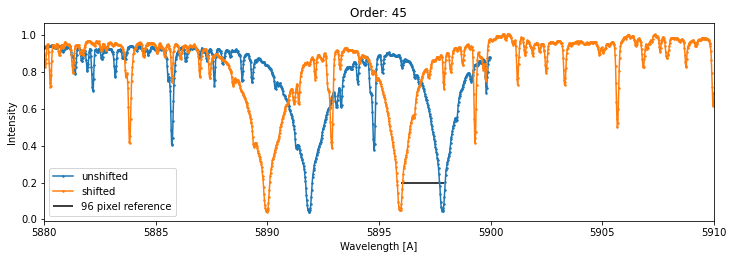

In [56]:
order = 45

# find order boundaries
apf_order = apf_wave[0].data[order]
low_bound = apf_order[0]
up_bound = apf_order[-1]

# define data for this order
idxs_order_shifted = (wl_shifted > low_bound) * (wl_shifted < up_bound) # order 40 for example
idxs_order_unshifted = (wl_unshifted > low_bound) * (wl_unshifted < up_bound)
flux_U = unshifted[idxs_order_unshifted]
flux_S = shifted[idxs_order_shifted]
wl_U = wl_unshifted[idxs_order_unshifted]
wl_S = wl_shifted[idxs_order_shifted]

# plot shifted and unshifted spectra for reference
plt.figure(figsize = [12,8])
plt.subplot(211)
plt.plot(wl_U, flux_U, '.-', label = 'unshifted', ms = 3)
plt.plot(wl_S, flux_S, '.-', label = 'shifted', ms = 3)
plt.hlines(0.2, xmin = 5896, xmax = wl_S[np.where(wl_S > 5896)[0][0] + 96], label = '96 pixel reference')
plt.xlabel('Wavelength [A]')
plt.ylabel('Intensity')
plt.xlim([5880,5910])
plt.title('Order: ' + str(order))
plt.legend()

And, let's just double check that the same pixel shift value applies to the other end of the spectum using order 32:

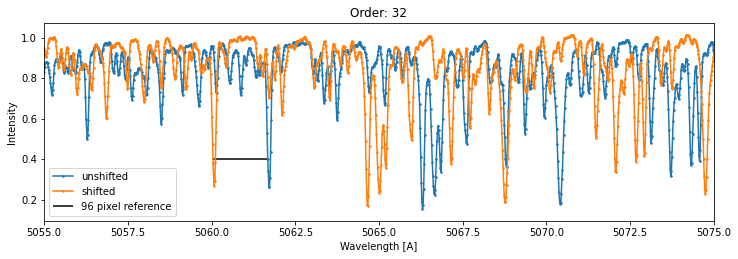

In [55]:
order = 32

# find order boundaries
apf_order = apf_wave[0].data[order]
low_bound = apf_order[0]
up_bound = apf_order[-1]

# define data for this order
idxs_order_shifted = (wl_shifted > low_bound) * (wl_shifted < up_bound) # order 40 for example
idxs_order_unshifted = (wl_unshifted > low_bound) * (wl_unshifted < up_bound)
flux_U = unshifted[idxs_order_unshifted]
flux_S = shifted[idxs_order_shifted]
wl_U = wl_unshifted[idxs_order_unshifted]
wl_S = wl_shifted[idxs_order_shifted]

# plot shifted and unshifted spectra for reference
plt.figure(figsize = [12,8])
plt.subplot(211)
plt.plot(wl_U, flux_U, '.-', label = 'unshifted', ms = 3)
plt.plot(wl_S, flux_S, '.-', label = 'shifted', ms = 3)
plt.hlines(0.4, xmin = 5060, xmax = wl_S[np.where(wl_S > 5060)[0][0] + 96], label = '96 pixel reference')
plt.xlabel('Wavelength [A]')
plt.ylabel('Intensity')
plt.xlim([5055,5075])
plt.title('Order: ' + str(order))
plt.legend()